Không sử dụng tập test, dùng tập train để train và test

## Import the libraries

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split    

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Dataloader

In [2]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

## Transformer

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

## File paths

In [4]:
train_1 = "../data/train_FD003.txt"
test_1 = "../data/test_FD003.txt"
rul_1 = "../data/RUL_FD003.txt"

## Tính toán RUL cho train

In [5]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train = pd.read_csv(train_1, sep=' ', header=None)
train.drop([26, 27], axis=1, inplace=True)
train.columns = column_names

train['Remaining RUL'] = ''
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,


In [6]:
max_cycle = train.groupby('ID Engine').count()

for idx in range(len(train)):
    train.loc[idx, 'Remaining RUL'] = max_cycle.loc[train.loc[idx, 'ID Engine'], 'Cycle']

train['Remaining RUL'] = train['Remaining RUL'] - train['Cycle']

In [7]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [8]:
train.shape
# Có đầy đủ 27 features ban đầu

(24720, 27)

## Load RUL

In [9]:
rul = pd.read_csv(rul_1, sep=' ', header=None)
rul.drop(rul.columns[1], axis=1, inplace=True)
rul.columns = ['RUL']
rul.head()

,RUL
0,44
1,51
2,27
3,120
4,101


## Tính toán RUL cho test

In [10]:
test = pd.read_csv(test_1, sep=' ', header=None)
test.drop([26, 27], axis=1, inplace=True)
test.columns = column_names

test['Remaining RUL'] = ''
test.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,


In [11]:
max_cycle_test = test.groupby('ID Engine').count()
max_cycle_test['Cycle'].head()

ID Engine
1    233
2    124
3    234
4     68
5    138
Name: Cycle, dtype: int64

In [12]:
rul.head()

,RUL
0,44
1,51
2,27
3,120
4,101


In [13]:
# Công thức tính toán RUL cho test có thể là:
# RUL cuối cùng (trong tập testtest) + Cycles đã trải qua - cột Cycle tương ứng
for idx in range(len(test)):
    test.loc[idx, 'Remaining RUL'] = rul.loc[test.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test.loc[test.loc[idx, 'ID Engine'], 'Cycle']

test['Remaining RUL'] = test['Remaining RUL'] - test['Cycle']

In [14]:
test.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,276
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,275
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,274
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,273
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,272


In [15]:
# Trong tập test, động cơ có số lượng vòng đời được chạy ít nhất là ID Engine = 1 với số vòng đời trong tập test là 31 dòng
test.groupby('ID Engine').count().min()[0]

np.int64(38)

## Standard data (train and test)

In [16]:
# Bỏ đi các cột setting sẽ không chuẩn hóa
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [17]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,0.0,0.355972,0.370523,0.308580,0.0,...,0.642857,0.239116,0.647755,0.0,0.272727,0.0,0.0,0.559524,0.446331,0.492366
1,1,2,0.0008,-0.0003,100.0,0.0,0.388759,0.399100,0.309360,0.0,...,0.654762,0.278567,0.685659,0.0,0.363636,0.0,0.0,0.488095,0.534836,0.490458
2,1,3,-0.0014,-0.0002,100.0,0.0,0.313817,0.353298,0.445398,0.0,...,0.636905,0.264526,0.564462,0.0,0.272727,0.0,0.0,0.404762,0.458577,0.488550
3,1,4,-0.0020,0.0001,100.0,0.0,0.487119,0.417107,0.237285,0.0,...,0.684524,0.245612,0.558909,0.0,0.363636,0.0,0.0,0.470238,0.391966,0.486641
4,1,5,0.0016,0.0000,100.0,0.0,0.196721,0.476218,0.321217,0.0,...,0.654762,0.252109,0.556736,0.0,0.363636,0.0,0.0,0.577381,0.543371,0.484733


In [18]:
# test.head()

## Load data

In [19]:
sequence_length = 30
batch_size = 64
epochs = 50
input_dim = 21 # Frome sensor 1 to sensor 21

In [20]:
data_train = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
# data_test = CMAPSSLoaderDataset(test, sequence_length=sequence_length)

train_data, validation_data = train_test_split(data_train, test_size=0.2, random_state=42)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
# validation_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [21]:
data_train.__len__()

21820

In [22]:
train_data.__len__()

17456

In [23]:
validation_data.__len__()

4364

In [24]:
train_loader.__len__()

341

In [25]:
validation_loader.__len__()

69

In [26]:
batch = next(iter(train_loader))
# print(batch)
seq, target = batch

# print(f'seq={seq}, shape={seq.shape}')
# print(f'target={target}, shape={target.shape}')

## Training model

In [27]:
def train(model, train_loader, validation_loader, epochs=epochs, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for batch in train_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)

            optimizer.zero_grad() # Reset gradient.
            output = model(seq) # Tính dự đoán từ mô hình.
            loss = criterion(output, target) # Tính giá trị mất mát giữa dự đoán và nhãn thật.
            loss.backward() # Tính gradient của mất mát.
            optimizer.step() # Cập nhật tham số mô hình dựa trên gradient.
            train_loss += loss.item() # Ghi nhận giá trị mất mát
        
        # Evaluate
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in validation_loader:
                seq, target = batch
                seq, target = seq.to(device), target.to(device)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(validation_loader)}")

In [28]:
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
train(model=model, train_loader=train_loader, validation_loader=validation_loader, epochs=epochs)

Epoch 1: Train Loss = 0.03269418547765688, Val Loss = 0.012582935467092455
Epoch 2: Train Loss = 0.016391627329382555, Val Loss = 0.011681790645841671
Epoch 3: Train Loss = 0.014333315798603108, Val Loss = 0.01239561162673045
Epoch 4: Train Loss = 0.013563763638384792, Val Loss = 0.011270769514089478
Epoch 5: Train Loss = 0.012856104439861876, Val Loss = 0.011639626494244389
Epoch 6: Train Loss = 0.012589806626630057, Val Loss = 0.010816130328221598
Epoch 7: Train Loss = 0.012224510064911195, Val Loss = 0.010949257207845432
Epoch 8: Train Loss = 0.01205389226221444, Val Loss = 0.010686915111390577
Epoch 9: Train Loss = 0.011582518736572385, Val Loss = 0.01087919738062698
Epoch 10: Train Loss = 0.011320568856037607, Val Loss = 0.010016963000584772
Epoch 11: Train Loss = 0.010804787473452667, Val Loss = 0.010117388910789421
Epoch 12: Train Loss = 0.010393949463155088, Val Loss = 0.009470618856341942
Epoch 13: Train Loss = 0.009768816403487474, Val Loss = 0.009460820263062698
Epoch 14: Tr

## Evaluate model

## Predict on a batch

In [29]:
len(validation_loader)

69

actual_predictions: [ 29.02449292 253.98318744  54.89786229  13.41388139 174.12229919
 133.67857468 126.60507178 219.06325507 131.93325269 246.61636138
  42.60066792 136.42592406  27.53096223  -0.58632569  82.60091352
 306.76474023  36.16572812   1.97767914 286.75639343 102.26858819
 130.61680436 170.9888339  202.50855696  40.56844893 125.37730908
  15.74668518  52.84384277  16.32773301  96.46406752   8.55396655
 118.46116501 185.10009372 183.00401139 198.88140988 162.17652106
  18.65915865 182.81294453 214.94501853 122.97966594 174.58257747
 156.82433772 349.20150995 123.52039999 114.26162159 153.23591936
  25.4212741   39.36440367 267.0590632   11.43108836 122.44182873
  38.12505358  12.66930234 153.24903715 225.75585794 397.11402011
 130.25572157  50.82557705 194.95928431 419.35563946 188.69022989
 362.90182376 264.46976757 200.12541366  95.49136776]
actual_targets: [ 19.99999982 268.99999642  52.00000188  11.0000001  158.00000405
 113.0000025  111.99999744 157.00000679  76.00000244

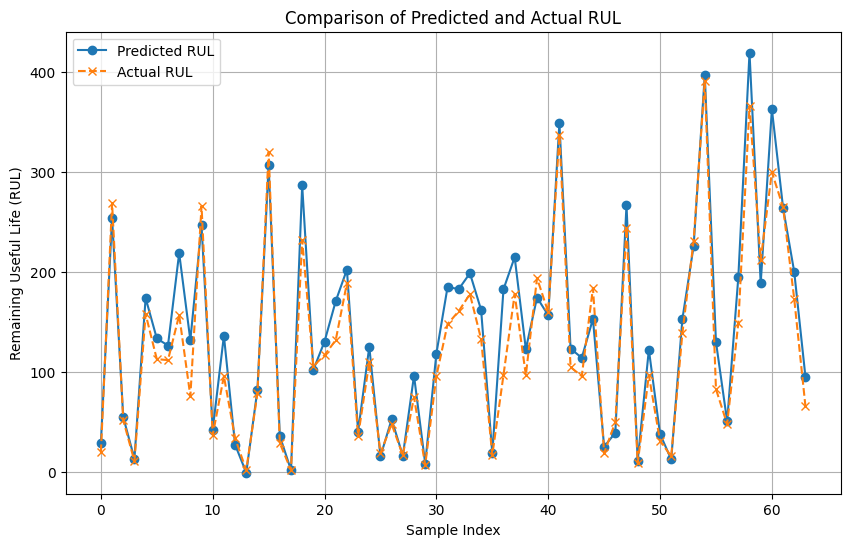

In [30]:
samples, targets = next(iter(validation_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
samples, targets = samples.to(device), targets.to(device)

model.eval()
with torch.no_grad():
    predictions = model(samples)

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

print(f'actual_predictions: {actual_predictions}')
print(f'actual_targets: {actual_targets}')

# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()

## Predict on a sample

In [31]:
samples.shape

torch.Size([64, 30, 21])

In [32]:
targets

tensor([0.0382, 0.5134, 0.0992, 0.0210, 0.3015, 0.2156, 0.2137, 0.2996, 0.1450,
        0.5076, 0.0706, 0.1832, 0.0649, 0.0038, 0.1508, 0.6107, 0.0553, 0.0038,
        0.4427, 0.2023, 0.2233, 0.2519, 0.3607, 0.0687, 0.2099, 0.0363, 0.0916,
        0.0324, 0.1431, 0.0134, 0.1832, 0.2824, 0.3073, 0.3397, 0.2538, 0.0324,
        0.1851, 0.3397, 0.1851, 0.3702, 0.3053, 0.6431, 0.2004, 0.1832, 0.3511,
        0.0363, 0.0954, 0.4656, 0.0172, 0.1851, 0.0592, 0.0305, 0.2653, 0.4408,
        0.7462, 0.1584, 0.0916, 0.2844, 0.6985, 0.4046, 0.5725, 0.5057, 0.3302,
        0.1260])

In [33]:
targets.shape

torch.Size([64])

In [34]:
idx = 0
sample = samples[idx].unsqueeze(0)
target = targets[idx].unsqueeze(0)

print(sample.shape)
print(target)

torch.Size([1, 30, 21])
tensor([0.0382])


In [35]:
model.eval()
with torch.no_grad():
    prediction = model(sample)

sample = sample.cpu()
target = target.cpu()
prediction = prediction.cpu()

print(f'Prediction: {prediction}')
print(f'Target: {target}')

rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

prediction = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_prediction = sum(prediction)/len(prediction)
actual_target = targets.numpy() * (rul_max - rul_min) + rul_min

# print(f'Giá trị RUL thực tế {actual_target}')
print(f'Giá trị RUL thực tế {actual_target[-1]}')
print(f'Giá trị RUL dự đoán {actual_prediction}')

Prediction: tensor([0.0554])
Target: tensor([0.0382])
Giá trị RUL thực tế 65.99999862909317
Giá trị RUL dự đoán 139.4404979258543


In [36]:
prediction

array([ 29.02449292, 253.98318744,  54.89786229,  13.41388139,
       174.12229919, 133.67857468, 126.60507178, 219.06325507,
       131.93325269, 246.61636138,  42.60066792, 136.42592406,
        27.53096223,  -0.58632569,  82.60091352, 306.76474023,
        36.16572812,   1.97767914, 286.75639343, 102.26858819,
       130.61680436, 170.9888339 , 202.50855696,  40.56844893,
       125.37730908,  15.74668518,  52.84384277,  16.32773301,
        96.46406752,   8.55396655, 118.46116501, 185.10009372,
       183.00401139, 198.88140988, 162.17652106,  18.65915865,
       182.81294453, 214.94501853, 122.97966594, 174.58257747,
       156.82433772, 349.20150995, 123.52039999, 114.26162159,
       153.23591936,  25.4212741 ,  39.36440367, 267.0590632 ,
        11.43108836, 122.44182873,  38.12505358,  12.66930234,
       153.24903715, 225.75585794, 397.11402011, 130.25572157,
        50.82557705, 194.95928431, 419.35563946, 188.69022989,
       362.90182376, 264.46976757, 200.12541366,  95.49

In [37]:
target

tensor([0.0382])